## 实验：权重与偏置初始化

### 实验概要

训练神经网络需要指定权重与偏置的初始值。一个精心设计的初始化权重值和偏置值方法，将有助于：

- 加速梯度下降的收敛
- 有助于模型收敛到较低点

如果想减小权重的值，一开始就将初始值设为较小的值的思路是正确的；然而，把权重初始值全部设为 0 以减小权重的值，会怎么样呢？

#### 零值初始化

通过下面的实验你很快会发现，从结论来说，将权重初始值设为 0 不是一个理想的选则。事实上，将权重初始值设为 0 的话，将无法正确进行学习。严格地说，应该是 **不能将权重初始值设成一样的值**，这是因为在误差反向传播法中，所有的权重值都会进行相同的更新。比如，在 2 层神经网络中，假设第 1 层和第 2 层的权重为 0。这样一来，正向传播时，因为输入层的权重为 0，所以第 2 层的神经元全部会被传递相同的值。第 2 层的神经元中全部输入相同的值，这意味着反向传播时第 2 层的权重全部都会进行相同的更新。因此，权重被更新为相同的值，并拥有了对称的值（重复的值）。这使得神经网络拥有许多不同的权重的意义丧失了。为了防止『权重均一化』（严格地讲，是为了瓦解权重的对称结构），必须随机生成初始值。

#### Xavier 初始值

在 Caffe 深度学习框架中， Xavier 初始值已被作为标准使用，通过在设定权重初始值时赋予 `xavier` 参数，就可以使用 Xavier 初始值。为了使各层的激活值呈现出具有相同广度的分布，推导了合适的权重尺度。所推导出的 Xavier 初始值是：如果前一层的节点数为 `n`，则初始值使用标准差为 $\frac{1}{\sqrt{n}}$ 的分布：

<img src="./img/1_16.png" width="50%">

**注意：** 在 TensorFlow 深度学习框架中，`Xavier 初始值` 也被称为 `Glorot 初始值`。

### 实验目标

在神经网络的学习中，权重的初始值特别重要。实际上，设定什么样的权重初始值，经常关系到神经网络的学习能否成功。

<img src="./img/4_16.png">

本实验将介绍权重初始值的推荐值，并通过实验确认神经网络的学习是否会快速进行。

### 1. 导入库

为了提升代码可读性，我们将神经网络中常用的依赖库、激活函数、参数更新函数、模型训练函数、预测函数、图形绘制函数等放在 `model` 目录下的 **`init_utils.py`** 文件中，并通过 `from import` 导入，使得代码更加简洁，相关源代码可直接查阅 **`init_utils.py`** 源文件。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets

import warnings
warnings.simplefilter('ignore')

### 2. 数据分布可视化

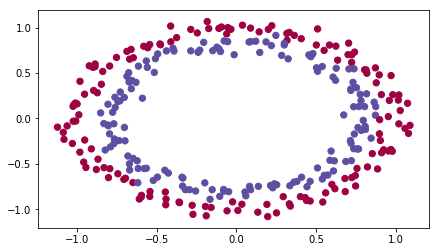

In [2]:
# 魔法指令，让matplotlib图形直接在 Jupyter Noterbook 中显示
%matplotlib inline

# 设置图形的默认大小
plt.rcParams['figure.figsize'] = (7.0, 4.0)     
# 设置插值为最近的
plt.rcParams['image.interpolation'] = 'nearest' 
# 设置颜色样式
plt.rcParams['image.cmap'] = 'gray'             

# 生成数据
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=np.squeeze(train_Y), s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y

# 加载图像数据集:蓝色/红色圆点在圆圈
train_X, train_Y, test_X, test_Y = load_dataset() 

从上图可以看到，我们需要训练一个神经网络模型分类器，来区分蓝点和红点。

### 3. 创建神经网络模型

我们将创建一个三层神经网络，使用以下三种权重初始化方法: 

- **零值初始化：** 将输入参数设置为 `initialization = "zeros"`
- **随机初始值：** 将输入参数设置为 `initialization = "random"`，这会将权重初始化为较大的随机值。 
- **He 初始值：** 将输入参数设置为 `initialization = "he"`，这将根据 He 等人 2015 年的一篇论文将权重初始化为按比例缩放的随机值。

#### 3.1 实现三层神经网络

首先，通过定义一个函数，实现三层神经网络，网络结构为：`LINEAR -> RELU -> LINEAR -> REL U-> LINEAR -> SIGMOID`

```python
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):```

- **`X`：** 输入数据，形状为（2, 样本数）
- **`Y`：** 真实的标签向量（`0` 为红点，`1` 为蓝点），形状为（1, Y 样本数）
- **`learning_rate`：** -- 梯度下降的学习率
- **`num_iterations`：** -- 运行梯度下降的迭代次数。这里设置了 `15000` 次
- **`print_cost`：** -- 如果为真，每 1000 次迭代输出损失值
- **`initialization`：** -- 标志要使用的初始化方法 (可选项：`"zeros"`, `"random"` 或 `"he"`)  

该函数返回值为：`parameters` 模型学习的参数。

In [3]:
# 定义 sigmoid 激活函数
def sigmoid(x):
    """
    计算 x 的 Sigmoid 函数

    参数：
    x -- 任意大小的标量或 numpy 数组。

    返回值:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

# 定义 relu 激活函数
def relu(x):
    """
    计算 x 的 relu 函数

    参数:
    x -- 任意大小的标量或 numpy 数组。

    返回值:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

# 定义前向传播函数
def forward_propagation(X, parameters):
    """
    实现正向传播（并计算损失）。
    
    参数:
    X -- 输入数据集，shape (输入大小、实例数)
    参数 -- 包含参数 "W1", "b1", "W2", "b2", "W3", "b3" 的 Python 字典:
                    W1 -- 权重矩阵 shape ()
                    b1 -- 偏差矢量 shape ()
                    W2 -- 权重矩阵 shape ()
                    b2 -- 偏差矢量 shape ()
                    W3 -- 权重矩阵 shape ()
                    b3 -- 偏差矢量 shape ()
    
    返回值:
    loss -- 损失函数(vanilla logistic loss)
    """
        
    # 获取参数
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

# 定义反向传播函数
def backward_propagation(X, Y, cache):
    """
    实现反向传播
    
    参数：
    X -- 输入数据集，shape (输入大小、实例数)
    Y -- 标签向量
    cache -- forward_propagation() 输出的 cache
    
    返回值:
    gradients -- 关于每个参数、激活和激活前变量的梯度字典
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

# 更新参数
def update_parameters(parameters, grads, learning_rate):
    """
    使用梯度下降更新参数
    
    参数:
    parameters -- 包含参数的 Python 字典
    grads -- 包含渐变的 Python 字典
    
    返回值:
    parameters -- 包含更新后参数的 Python 字典
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    """
    # 神经网络中的层数
    L = len(parameters) // 2 

    # 更新每个参数的规则
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

# 定义损失函数
def compute_loss(a3, Y):
    
    """
    实现损失函数
    
    参数:
    a3 -- 激活后，正向传播的输出
    Y -- 标签向量，与 a3 的 shape 相同
    
    返回值:
    loss - 损失函数的值
    """
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

# 定义预测函数
def predict(X, y, parameters):
    """
    该函数用于预测 n 层神经网络的结果。
    
    参数:
    X -- 进行标签的数据集
    parameters -- 训练模型的参数
    
    返回值:
    p -- 对给定数据集 X 的预测
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # 正向传播
    a3, caches = forward_propagation(X, parameters)
    
    # 将概率转换为 0/1 预测
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # 打印结果
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

# 决策边界绘制函数
def plot_decision_boundary(model, X, y):
    # 设置最小值和最大值，并给它一些填充
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # 生成点之间距离为 h 的网格
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # 预测整个网格的函数值
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # 绘制轮廓图和训练示例
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=np.squeeze(y), cmap=plt.cm.Spectral)
    plt.show()
    

def predict_dec(parameters, X):
    """
    用于绘制决策边界。
    
    参数:
    parameters -- 包含参数的 Python 字典
    X -- 输入数据大小 (m, K)
    
    返回值
    predictions -- 模型的预测向量 (red: 0 / blue: 1)
    """
    
    # 使用前向传播和0.5的分类阈值进行预测
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions


# 定义模型
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
        
    grads = {}
    # 记录损失情况
    costs = []                              
    # 样本数量
    m = X.shape[1]                          
    # 每层的神经单元数，分别是第0层，第一层
    layers_dims = [X.shape[0], 10, 5, 1]    
    
    # 初始化参数字典
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    for i in range(0, num_iterations): # 循环，梯度下降

        # 正向传播: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Loss 损失
        cost = compute_loss(a3, Y)

        # 反向传播
        grads = backward_propagation(X, Y, cache)
        
        # 参数更新
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # 每1000次打印损失值
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)
            
    # 绘制损失值
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

注意：上面正向传播: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID 神经网络结构，在 `init_utils.py` 文件中 `def forward_propagation(X, parameters)` 函数被定义 ——

```
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)```

### 4. 零值初始化

在神经网络中有两种类型的参数需要初始化：

- **权重值：** $(W^{[1]}, W^{[2]}, W^{[3]}, ..., W^{[L-1]}, W^{[L]})$
- **偏置值：** $(b^{[1]}, b^{[2]}, b^{[3]}, ..., b^{[L-1]}, b^{[L]})$

#### 4.1 零值初始化权重和偏置

以下函数的输入参数 `layers_dims` 是一个 Python 数组 (列表)，包含每一层的形状，权重值的形状与相邻层相关，下图为正向传播时的形状。

<img src="./img/2_16.png" width="65%">

该函数返回值为：`parameters`，是一个 Python 字典，包含了用于训练神经网络的参数：`W1`，`b1`，...，`WL`，`bL`，其中 ——

- **`W1`：** 形状的权重矩阵 `(layers_dims[1], layers_dims[0])`
- **`b1`：** 形状的偏置向量 `(layers_dims[1], 1)`
...
- **`WL`：** 形状的权重矩阵 `(layers_dims[L], layers_dims[L-1])`
- **`bL`：** 形状的偏置向量 `(layers_dims[L], 1)`

In [4]:
def initialize_parameters_zeros(layers_dims):
    
    parameters = {}
    #  网络的层数
    L = len(layers_dims)            
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

In [5]:
parameters = initialize_parameters_zeros([3,2,1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


#### 4.2 零值初始化模型训练

运行以下代码，使用零初始化（`initialization = "zeros"`）对模型进行 15,000 次迭代（在 `model()` 函数中定义）。

Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599455
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


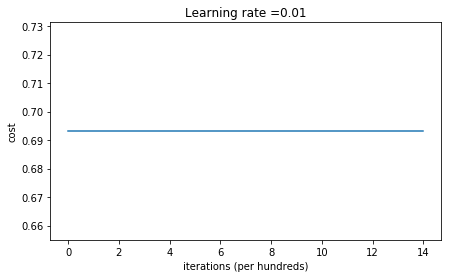

训练集: 
Accuracy: 0.5
测试集: 
Accuracy: 0.5


In [6]:
parameters = model(train_X, train_Y, initialization = "zeros")
print ("训练集: ")
predictions_train = predict(train_X, train_Y, parameters)
print ("测试集: ")
predictions_test = predict(test_X, test_Y, parameters)

从上面的结果可以看到，性能是非常糟糕的，模型并没有真正的降低损失。算法的表现甚至没有比随机猜测更好。让我们看看预测和决策边界的细节:

#### 4.3 零值初始化预测细节

In [7]:
print ("predictions_train = " + str(predictions_train))
print ("predictions_test = " + str(predictions_test))

predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


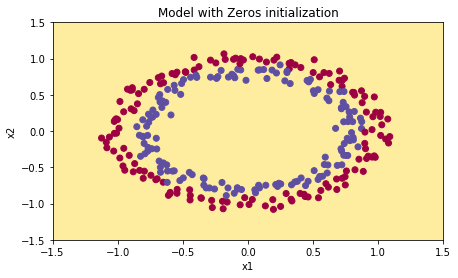

In [8]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

模型对每个例子的预测都是 0。

一般来说，将所有权值初始化为零会导致网络无法破坏对称性。这意味着每一层中的每一个神经元都将学习相同的东西，你也可以将 `np.zeros` 替换为 `np.one` 来训练一个神经网络，这个网络估计并不比线性分类器 ( 比如：logistic 回归 ) 更强大。**你应该记住的是**：

- 权重 $W^{[1]}$ 应该被随机初始值以打破对称性。
- 满足上述条件的前提下，偏置 $b^{[1]}$ 可以被初始化为 `0`。因为随机初始化 $W^{[1]}$ 仍然破坏了对称性。

### 5. 随机初始值

为了打破对称性，让权重随机化。在随机初始化之后，每个神经元可以继续学习其输入的不同函数。我们将看到如果权重被随机地初始化，但是权重是非常大的值会发生什么。执行以下函数，将权重初始化为大的随机值(按乘以 `10` 的比例缩放)，并将偏差初始化为零。

#### 5.1 随机初始化权重和偏置

以下函数设置

- **权重值：** `np.random.randn() * 10`
- **偏置值：** `np.zero()`

另外，使用固定的 `np.random.seed()` 来确保随机权重保持一致。

该函数返回值为：`parameters`，是一个 Python 字典，包含了用于训练神经网络的参数：`W1`，`b1`，...，`WL`，`bL`，其中 ——

- **`W1`：** 形状的权重矩阵 `(layers_dims[1], layers_dims[0])`
- **`b1`：** 形状的偏置向量 `(layers_dims[1], 1)`
...
- **`WL`：** 形状的权重矩阵 `(layers_dims[L], layers_dims[L-1])`
- **`bL`：** 形状的偏置向量 `(layers_dims[L], 1)`

In [9]:
def initialize_parameters_random(layers_dims):
    # 该随机种子确保随机数字保持一致
    np.random.seed(3)               
    parameters = {}
    # 表示层数的整数变量
    L = len(layers_dims)            
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10 
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))

    return parameters

In [10]:
parameters = initialize_parameters_random([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 17.88628473   4.36509851   0.96497468]
 [-18.63492703  -2.77388203  -3.54758979]]
b1 = [[0.]
 [0.]]
W2 = [[-0.82741481 -6.27000677]]
b2 = [[0.]]


#### 5.2 随机初始值模型训练

运行以下代码，使用随机初始值对模型进行 15,000次 迭代训练。

Cost after iteration 0: inf
Cost after iteration 1000: 0.6247924745506072
Cost after iteration 2000: 0.5980258056061102
Cost after iteration 3000: 0.5637539062842213
Cost after iteration 4000: 0.5501256393526495
Cost after iteration 5000: 0.5443826306793814
Cost after iteration 6000: 0.5373895855049121
Cost after iteration 7000: 0.47157999220550006
Cost after iteration 8000: 0.39770475516243037
Cost after iteration 9000: 0.3934560146692851
Cost after iteration 10000: 0.3920227137490125
Cost after iteration 11000: 0.38913700035966736
Cost after iteration 12000: 0.3861358766546214
Cost after iteration 13000: 0.38497629552893475
Cost after iteration 14000: 0.38276694641706693


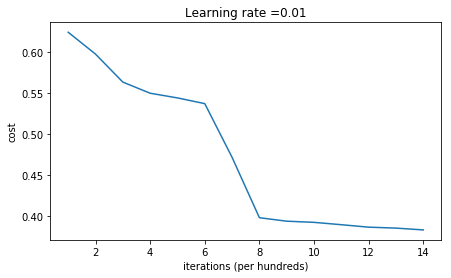

训练集: 
Accuracy: 0.83
测试集: 
Accuracy: 0.86


In [11]:
parameters = model(train_X, train_Y, initialization = "random")
print ("训练集: ")
predictions_train = predict(train_X, train_Y, parameters)
print ("测试集: ")
predictions_test = predict(test_X, test_Y, parameters)

如果你看到 `inf` 这个是迭代 `0` 之后的损失值，这是因为数值舍入，目标不需要担心。从上面的结果看来，我们破坏了对称性，这就得到了更好的结果。

#### 5.3 随机初始值预测细节 

In [12]:
print (predictions_train)
print (predictions_test)

[[1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1
  1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0
  0 0 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0
  1 0 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0
  0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1
  1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1
  0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 1 1 0 1 1
  1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1
  1 1 1 1 0 0 0 1 1 1 1 0]]
[[1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 0 0 0 1
  0 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0
  1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0]]


[与之前相比](#4.3-%E9%9B%B6%E5%88%9D%E5%A7%8B%E5%8C%96%E9%A2%84%E6%B5%8B%E7%BB%86%E8%8A%82)，模型不再输出所有 `0`。

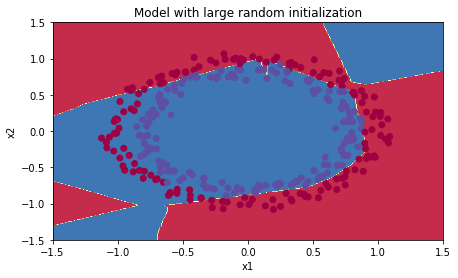

In [13]:
plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

从实验过程可以观察到：

- 损失值一开始就很高。这是因为对于大型随机值权重，最后一个激活(sigmoid)在某些样本中输出的结果非常接近于 `0` 或 `1`，而当它错误地分类该样本时，会对该样本造成非常大的损失值。即：$\log \left(a^{[3]}\right)=\log (0)$ 时，损失值趋于无穷大。
- 初始化值选择错误，会导致梯度消失/爆炸，这也会减慢优化算法。
- 如果你训练这个网络的时间足够长，你会看到更好的结果，但初始化过大的随机数，仍然会降低优化速度。

通过上面两个极端的训练：初始化为 0 和初始化为极大随机值，都证明并不能很好地工作。所以，我们希望用更小的随机值使得初始化效果更好。

问题是：这些随机值应该有多小？

### 6. He 初始值

最后，尝试 `He 初始值`；与 [Xavier 初始值](#Xavier-%E5%88%9D%E5%A7%8B%E5%80%BC) 类似，只是比例因子不同：如果前一层的节点数为 `n`，则 `He 初始值` 使用标准差为 $\frac{2}{\sqrt{n}}$ 的分布

#### 6.1 He 初始值权重和偏置

执行以下函数来初始化参数。这个函数和 [前面的](#5.1-%E9%9A%8F%E6%9C%BA%E5%88%9D%E5%A7%8B%E5%8C%96%E6%9D%83%E9%87%8D%E5%92%8C%E5%81%8F%E7%BD%AE) `initialize_parameters_random()`类似，唯一的不同就是不用乘以 `10`，而是乘以 $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$，这是算法作者对 ReLU 激活的层的初始化建议。

以下函数设置

- **权重值：** `np.random.randn() * np.sqrt(2/layers_dims[l-1])`
- **偏置值：** `np.zero()`

另外，使用固定的 `np.random.seed()` 来确保随机权重保持一致。

该函数返回值为：`parameters`，是一个 Python 字典，包含了用于训练神经网络的参数：`W1`，`b1`，...，`WL`，`bL`，其中 ——

- **`W1`：** 形状的权重矩阵 `(layers_dims[1], layers_dims[0])`
- **`b1`：** 形状的偏置向量 `(layers_dims[1], 1)`
...
- **`WL`：** 形状的权重矩阵 `(layers_dims[L], layers_dims[L-1])`
- **`bL`：** 形状的偏置向量 `(layers_dims[L], 1)`

In [14]:
def initialize_parameters_he(layers_dims):
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1])*np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [15]:
parameters = initialize_parameters_he([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.78862847  0.43650985]
 [ 0.09649747 -1.8634927 ]
 [-0.2773882  -0.35475898]
 [-0.08274148 -0.62700068]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.03098412 -0.33744411 -0.92904268  0.62552248]]
b2 = [[0.]]


#### 6.2 He 初始值模型训练

运行以下代码，使用He初始化对模型进行 15,000 次迭代训练。

Cost after iteration 0: 0.8830537463419761
Cost after iteration 1000: 0.6879825919728063
Cost after iteration 2000: 0.6751286264523371
Cost after iteration 3000: 0.6526117768893805
Cost after iteration 4000: 0.6082958970572938
Cost after iteration 5000: 0.5304944491717495
Cost after iteration 6000: 0.4138645817071794
Cost after iteration 7000: 0.3117803464844441
Cost after iteration 8000: 0.23696215330322562
Cost after iteration 9000: 0.1859728720920684
Cost after iteration 10000: 0.15015556280371808
Cost after iteration 11000: 0.12325079292273551
Cost after iteration 12000: 0.09917746546525937
Cost after iteration 13000: 0.08457055954024283
Cost after iteration 14000: 0.07357895962677366


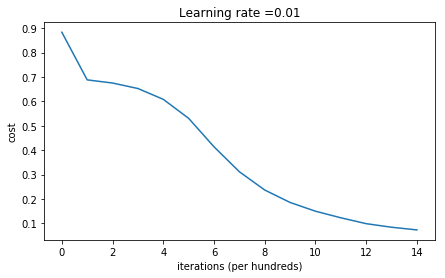

训练集: 
Accuracy: 0.9933333333333333
测试集: 
Accuracy: 0.96


In [16]:
parameters = model(train_X, train_Y, initialization = "he")
print ("训练集: ")
predictions_train = predict(train_X, train_Y, parameters)
print ("测试集: ")
predictions_test = predict(test_X, test_Y, parameters)

#### 6.3 He 初始值预测细节

In [17]:
print (predictions_train)
print (predictions_test)

[[1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 1 1 0 1 1 0 0 0
  0 1 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 0
  0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0
  0 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0
  0 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0
  1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 1 0 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1
  0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0
  1 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 1
  1 1 1 0 0 0 0 1 1 0 1 0]]
[[1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1
  0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0
  1 1 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0]]


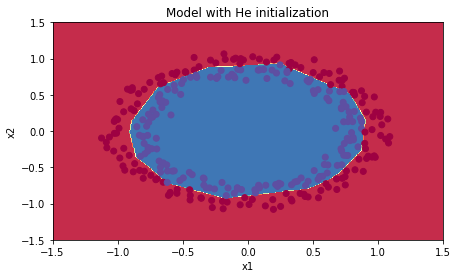

In [18]:
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

从上图可知：具有 He 初始值的模型在少量的迭代中很好地分离了蓝色和红色的点。

### 实验小结

在本实验中，你通过逐步测试，从零开始，到随机初始化极大值，到最后 HE 初始值权重与偏置的初始值，了解了初始化值对模型训练的影响效果。同时，通过实验确认神经网络的学习是否会快速进行。综上所述，当前权重与偏置初始化的几种方案对比如下：

| 模型                                      | 准确率 | 评价         |
| :------------------------------------------- | :--------------: | -----------------------: |
| 三层神经网络：零值初始化        | 50%            | 无法打破对称性 |
| 三层神经网络：极大随机值初始化 | 83%            | 权重初始化值过大，训练时间太长       |
| 三层神经网络：He 初始值          | 99%            | 推荐值      |

另外，Xavier 初始值是以激活函数是线性函数为前提而推导出来的。因为 sigmoid 函数和 tanh 函数左右对称，且中央附近可以视作线性函数，所以适合使用 Xavier 初始值。但当激活函数使用 ReLU 时，一般推荐使用 ReLU 专用的初始值，也就是 Kaiming He 等人推荐的初始值，也称为 `He 初始值`。即当前一层的节点数为 n 时， He 初始值使用标准差为 $\frac{2}{\sqrt{n}}$ 的高斯分布。相对于 Xavier 初始值是 $\frac{1}{\sqrt{n}}$ ，直观上可以解释为，因为 ReLU 的负值区域的值为 0，为了使它更有广度，所以需要 2 倍的系数。因此：

- 当激活函数使用 `ReLU` 时，权重初始值使用 `He 初始值`
- 当激活函数为 `sigmoid` 或 `tanh` 等 S 型曲线函数时，初始值使用 `Xavier 初始值`

这是目前的最佳实践选择。

<img src="./img/3_16.png" width="80%">